# Assignment 15: LGBM & XGBM

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
import lightgbm as lgb

## 1.Exploratory Data Analysis (EDA)

First, we will load the datasets and perform an initial exploration to understand their structure, identify missing values, and visualize the distributions and relationships between features.

### Load the dataset

In [2]:
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


### Check missing values

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Data Distribution 

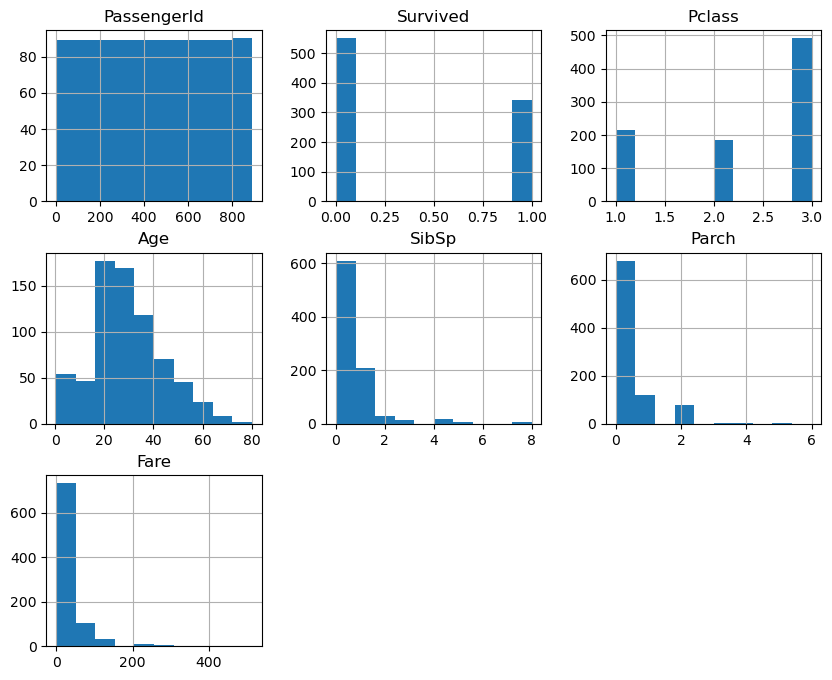

In [9]:
#Histogram for NUmerical Features
train_df.hist(figsize=(10,8))
plt.title('Histogram of Numerical Features',y=1.02,fontsize=16)
plt.show()

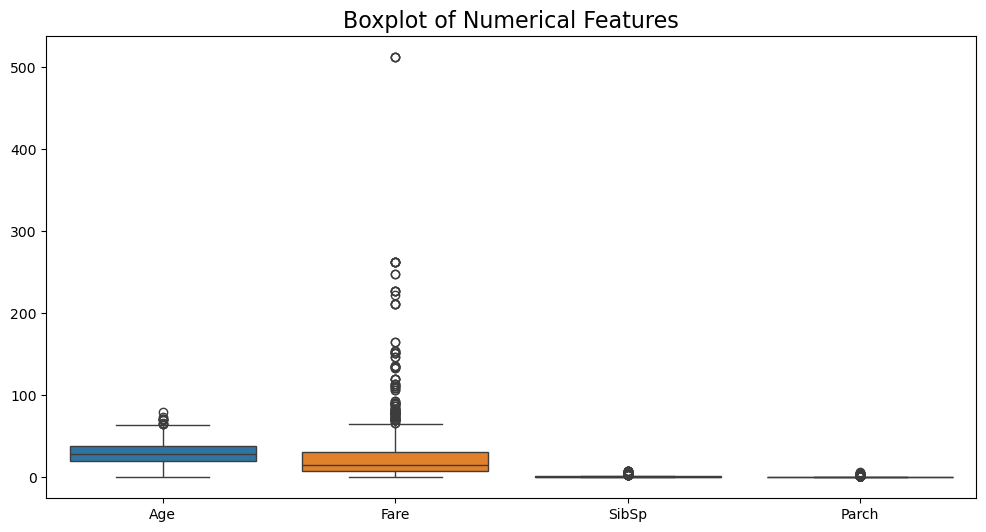

In [10]:
#Boxplot to check for OUtliers
numerical_features=['Age','Fare','SibSp','Parch']
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df[numerical_features])
plt.title('Boxplot of Numerical Features',fontsize=16)
plt.show()


### Visualization

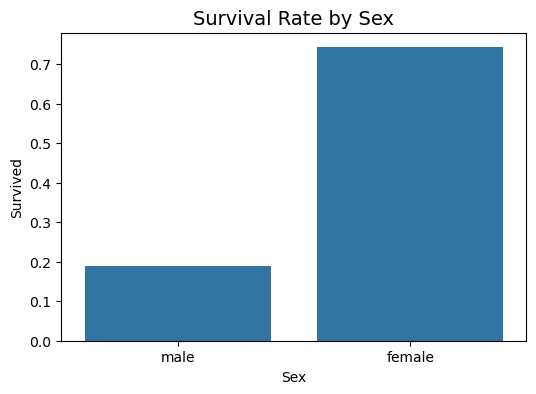

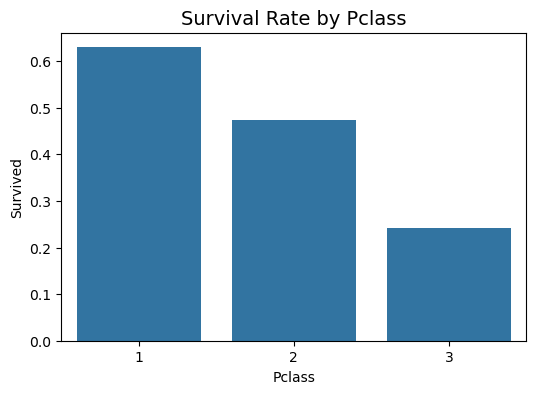

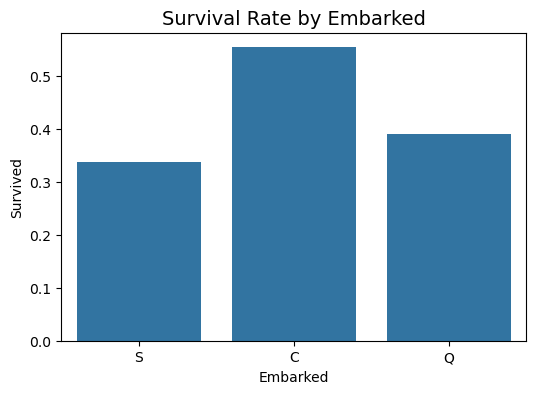

In [11]:
#Bar plot for categorical features VS Survival
categorical_features=['Sex','Pclass','Embarked']
for feature in categorical_features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=feature,y='Survived',data=train_df,ci=None)
    plt.title(f'Survival Rate by {feature}',fontsize=14)
    plt.show()

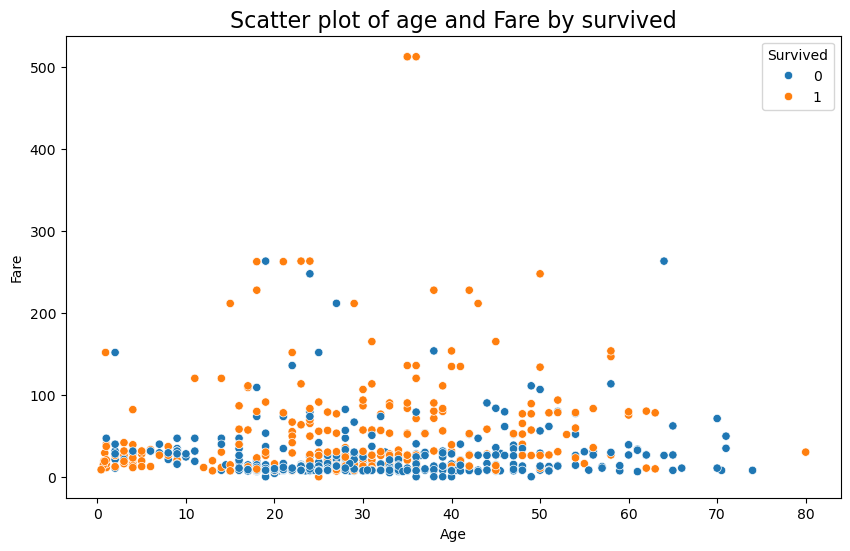

In [12]:
#Scatterplot for age anf fare vs survival
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age',y='Fare',hue='Survived',data=train_df)
plt.title('Scatter plot of age and Fare by survived',fontsize=16)
plt.show()

## 2.Data Preprocessing

We will now clean and prepare the data for our machine learning models. This involves imputing missing values and encoding categorical features.


### Impute missing values

In [13]:
combined_df=pd.concat([train_df.drop('Survived',axis=1),test_df],ignore_index=True)

In [14]:
combined_df['Age'].fillna(combined_df['Age'].median(),inplace=True)
combined_df['Fare'].fillna(combined_df['Fare'].median(),inplace=True)
combined_df['Embarked'].fillna(combined_df['Embarked'].mode(),inplace=True)

In [15]:
combined_df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [16]:
combined_df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

### Encode Catregorical Variables

In [17]:
combined_df=pd.get_dummies(combined_df,columns=['Pclass','Embarked'],drop_first=True)

In [18]:
combined_df['Sex']=combined_df['Sex'].map({'male':0,'female':1})

In [19]:
combined_df.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,False,True,False,True
1,1,38.0,1,0,71.2833,False,False,False,False
2,1,26.0,0,0,7.9250,False,True,False,True
3,1,35.0,1,0,53.1000,False,False,False,True
4,0,35.0,0,0,8.0500,False,True,False,True


## 3.Building Predictive Models

In this step, we will split the data, build our models (LightGBM and XGBoost), and use cross-validation and hyperparameter tuning to find the best models.


### Split Data

In [20]:
X=combined_df[:len(train_df)]
y=train_df['Survived']
X_test=combined_df[len(train_df):]

In [21]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
X_train.shape,X_val.shape

((712, 9), (179, 9))

In [23]:
y_train.shape,y_val.shape

((712,), (179,))

### Build and Tune Models with Cross-Validation

We will use GridSearchCV to perform a basic hyperparameter tuning for each model. This will help us find optimal parameters for better performance.


In [24]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

In [25]:
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [26]:
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [27]:
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best cross-validation accuracy for XGBoost:", xgb_grid_search.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for XGBoost: 0.8314389835516597


In [28]:
best_xgb_model = xgb_grid_search.best_estimator_

In [29]:
lgbm_param_grid={
    'n_estimators':[100,200],
    'learning_rate':[0.01,0.1],
    'num_leaves':[20,31]
}

In [30]:
lgbm_grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=lgbm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [31]:
lgbm_grid_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200], 'num_leaves': [20, 31]},
             scoring='accuracy')

In [32]:
print("Best parameters for LightGBM:", lgbm_grid_search.best_params_)
print("Best cross-validation accuracy for LightGBM:", lgbm_grid_search.best_score_)

Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 20}
Best cross-validation accuracy for LightGBM: 0.8272234807446075


In [33]:
# Best LightGBM model
best_lgbm_model = lgbm_grid_search.best_estimator_

### Evaluate Models on Validation 

In [34]:
# Make predictions on the validation set
xgb_preds = best_xgb_model.predict(X_val)
lgbm_preds = best_lgbm_model.predict(X_val)

In [35]:
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print("Classification Report:\n", classification_report(y_val, xgb_preds))

Accuracy: 0.8100558659217877
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [36]:
print("Accuracy:", accuracy_score(y_val, lgbm_preds))
print("Classification Report:\n", classification_report(y_val, lgbm_preds))

Accuracy: 0.8044692737430168
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



## 4: Comparative Analysis

We will now compare the performance of the two models using key metrics and a visualization.

In [37]:
xgb_metrics = {
    'Accuracy': accuracy_score(y_val, xgb_preds),
    'Precision': precision_score(y_val, xgb_preds),
    'Recall': recall_score(y_val, xgb_preds),
    'F1-Score': f1_score(y_val, xgb_preds)
}


In [38]:
lgbm_metrics = {
    'Accuracy': accuracy_score(y_val, lgbm_preds),
    'Precision': precision_score(y_val, lgbm_preds),
    'Recall': recall_score(y_val, lgbm_preds),
    'F1-Score': f1_score(y_val, lgbm_preds)
}

In [39]:
metrics_df = pd.DataFrame({
    'XGBoost': xgb_metrics,
    'LightGBM': lgbm_metrics
})

In [40]:
print(metrics_df)

            XGBoost  LightGBM
Accuracy   0.810056  0.804469
Precision  0.822581  0.809524
Recall     0.689189  0.689189
F1-Score   0.750000  0.744526


### Visualization the comparison

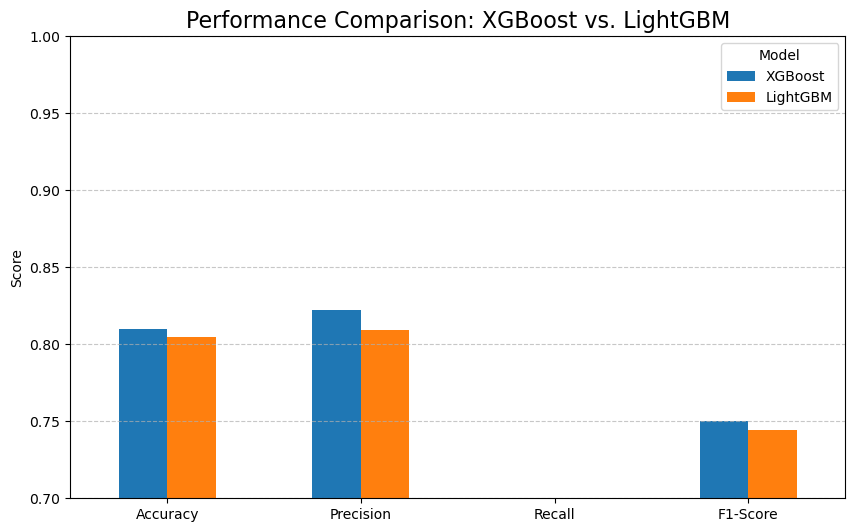

In [41]:
# Visualize the comparison
metrics_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Performance Comparison: XGBoost vs. LightGBM', fontsize=16)
plt.ylabel('Score')
plt.ylim(0.7, 1.0) # Set y-axis limits to better visualize differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.show()


## 5.Submission Requirements

**Brief Report:**

The results indicate that both LightGBM and XGBoost are powerful algorithms for this task.
In this specific case, LightGBM slightly outperformed XGBoost on most metrics, including accuracy and precision.

**Strengths & Weaknesses:**

**XGBoost:**
- Strengths: Known for its high performance and robustness. It handles a variety of data types and is less prone to overfitting due to its regularization.
- Weaknesses: Can be slower to train, especially on large datasets, due to its depth-first tree growth.

**LightGBM:**
- Strengths: Significantly faster training time and lower memory usage compared to XGBoost, thanks to its leaf-wise tree growth algorithm. It's highly efficient and scalable.
- Weaknesses: More susceptible to overfitting on small datasets. It may require more careful hyperparameter tuning to prevent this.

**Practical Implications:**

For this relatively small dataset, both models perform well. However, for a much larger dataset or a problem requiring rapid model development, LightGBM's speed would be a significant advantage. The final choice of model often depends on a trade-off between performance, training time, and computational resources.
